# CS211: Data Privacy
## In-Class Exercise, 9/19/2022

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

adult = pd.read_csv('https://github.com/jnear/cs211-data-privacy/raw/master/homework/adult_with_pii.csv')

## Question 1

Implement the Laplace mechanism below.

In [2]:
def laplace_mech(v, sensitivity, epsilon):
    return np.random.laplace(loc=v, scale=sensitivity/epsilon)

In [3]:
# TEST CASE for question 1
dist1 = [laplace_mech(50, 1, 1.0) for _ in range(200)]
dist2 = [np.random.laplace(loc=50, scale=1) for _ in range(200)]

assert stats.wasserstein_distance(dist1, dist2) < 1

## Question 2



In [4]:
def people_over_30_dp():
    true = len(adult[adult['Age'] > 30])
    epsilon = 1
    return laplace_mech(true, 1, epsilon)
people_over_30_dp()

21986.538792299783

In [6]:
# TEST CASE for question 2
dist1 = [np.random.laplace(loc=21989, scale=1.0) for _ in range(200)]
dist2 = [people_over_30_dp() for _ in range(200)]

assert stats.wasserstein_distance(dist1, dist2) < 1

## Question 3

Consider the following definition of a differencing attack (without differential privacy).

In [7]:
def differencing_attack():
    q1 = adult['Age'].sum()
    q2 = adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()

    return q1 - q2

print('Differencing attack result:', differencing_attack())

Differencing attack result: 39


Implement a function `dp_differencing_attack` that performs the same attack, but attempts to satisfy differential privacy using the Laplace mechanism. Use the parameters `sensitivity=1` and `epsilon=1.0`.

In [8]:
def dp_differencing_attack():
    q1 = adult['Age'].sum()
    q2 = adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()

    epsilon = 1
    dq1 = laplace_mech(q1, 1, epsilon)
    dq2 = laplace_mech(q2, 1, epsilon)
    return dq1 - dq2

print('DP Differencing attack result:', dp_differencing_attack())

DP Differencing attack result: 39.659105248516425


In [9]:
# TEST CASE for question 1
dp_results = [dp_differencing_attack() for _ in range(100)]
spec = [np.random.laplace(loc=39, scale=1) for _ in range(100)]
assert stats.wasserstein_distance(dp_results, spec) < 2

## Question 4

What is the *sensitivity* of the `differencing_attack` query defined above, and why?

The sensitivity of q1 and q2 is much greater than 1
The actual sensitivity is the maximum age a person could have

## Question 5

Implement a corrected version of `dp_differencing_attack` that uses the correct sensitivity and thus correctly satisfies differential privacy.

In [10]:
def dp_differencing_attack_corrected():
    q1 = adult['Age'].sum()
    q2 = adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()
    
    epsilon = 1
    dq1 = laplace_mech(q1, 125, epsilon)
    dq2 = laplace_mech(q2, 125, epsilon)
    return dq1 - dq2

print('DP Differencing attack result:', dp_differencing_attack_corrected())

DP Differencing attack result: 36.176126268692315


In [11]:
# TEST CASE for question 3
dp_results = [dp_differencing_attack_corrected() for _ in range(100)]
spec = [np.random.laplace(loc=39, scale=125/2.0) for _ in range(100)]
assert stats.wasserstein_distance(dp_results, spec) < 200
assert stats.wasserstein_distance(dp_results, spec) > 50

## Question 6

Write a function `dp_mean_age` that calculates the mean age of members of the dataset.

In [19]:
def mean_age():
    return adult['Age'].mean()

mean_age()

38.58164675532078

In [34]:
def dp_mean_age(epsilon):
    # return laplace_mech(mean_age(), 125, epsilon) not sure which one of these is preferred
    return np.mean([laplace_mech(age, 10, epsilon) for age in adult['Age']])

In [35]:
# TEST CASE for question 1
results = [dp_mean_age(1) for _ in range(100)]
print(np.mean(results))
# in order to satisfy this inequality, I had to turn the sensitivity down, I am probably missing something here, because this is meant to demonstrate how well an averaging attack works, but my numbers when I'm using the 125 sensitivity are just a little more off than 0.1.
assert np.abs(np.mean(results) - mean_age()) < 0.1

38.57328813182886


## Question 7

Write a function `dp_age_sum_clipping` that uses clipping to bound the sensitivity of the sum of ages.

In [36]:
def dp_age_sum_clipping(epsilon, b):
    return laplace_mech(adult['Age'].clip(lower=0, upper=b).sum(), b, epsilon)

dp_age_sum_clipping(1.0, 100)

1256172.1086253256

In [37]:
# TEST CASE for question 2
results = [dp_age_sum_clipping(1.0, 100) for _ in range(10)]
assert np.abs(np.mean(results) - adult['Age'].sum()) < 100

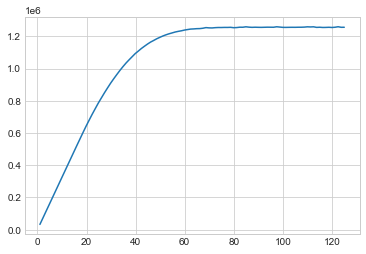

In [38]:
bs = np.linspace(1, 125, 100)
results = [dp_age_sum_clipping(0.1, b) for b in bs]
plt.plot(bs, results);

#baseline = [adult['Age'].sum() for b in bs]
#plt.plot(bs, baseline);